# The data
This notebook aims at presenting the process of creating the end-to-end modelling pipeline with the use of [PyPlatypus](https://github.com/maju116/pyplatypus) package.

As starting point, the data is crucial, let's proceed with gathering it hence. We will be working with the Chest X-ray images of which the [SIIM ACR Pneumothorax Segmentation dataset](https://www.kaggle.com/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data?datasetId=246422&sortBy=dateCreated) is composed. These are DICOM files organized in accordance with the following structure:

dicom-images-train

----|image_name_1

--------|image_name_1.dcm

----|image_name_2

--------|image_name_2.dcm

In each folder you will find a DICOM image of shape (1024, 1024, 1) - GRAYSCALE - with the values varying from 0 to 255, while the masks are written using RLE encoding in the `train-rle.csv` file. For now [PyPlatypus](https://github.com/maju116/pyplatypus) dosen't support RLE encodings so wi will save mask as (1024, 1024, 3) PNG images with the values coming from the discrete set: {[0, 0, 0], [255, 255, 255]} - colormap needed to assign pixel to a specific class. In our case it will be binary semantic segmentation.

Note that [PyPlatypus](https://github.com/maju116/pyplatypus) can work with multiple images and masks per sample of type PNG, JPG, JPEG, DICOM and TIFF. To see mre examples vivit [PyPlatypus website](https://maju116.github.io/pyplatypus/)

# The preparation
After downloading the data, unpack it and move to any preferred destination. For this example we will be interested only in dicom-images-train subdirectory and train-rle.csv file, thus other files could be put aside. Let's take a look at the exemplary image.

In [ ]:
! pip install pyplatypus

In [3]:
import pandas as pd
import pydicom
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from pathlib import Path
import shutil
import sys
from pathlib import Path
import os
from PIL import Image

In [4]:
cwd = Path.cwd()
while cwd.stem != "pyplatypus":
    cwd = cwd.parent
os.chdir(cwd)

In [3]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [62]:
def prepare_train_val_data(
        raw_data_paths: list[Path],
        csv_path: Path,
        data_path: Path,
        val_train_ratio: float=0.2
):
    training_data_path = data_path + "/siim_training"
    validation_data_path = data_path + "/siim_validation"
    
    Path(training_data_path).mkdir(parents=True, exist_ok=True)
    Path(validation_data_path).mkdir(parents=True, exist_ok=True)
    
    data_df = pd.read_csv(csv_path)
    width, height = 1024, 1024
    not_empty_masks = list()

    for idx, path in enumerate(raw_data_paths):
        file_name = path.split('/')[-1][:-4]
        if all(data_df["ImageId"] != file_name):
            continue
        data_path = validation_data_path if np.random.uniform() <= val_train_ratio else training_data_path
        Path(f"{data_path}/image_{idx}").mkdir(parents=True, exist_ok=True)
        rle_mask = data_df[data_df["ImageId"] == file_name][" EncodedPixels"].values[0]
        if  "-1" in rle_mask:
            mask = np.zeros((width, height))
        else:
            mask = rle2mask(rle_mask, width, height)
            not_empty_masks.append(idx)
        Path(f"{data_path}/image_{idx}/images").mkdir(parents=True, exist_ok=True)
        Path(f"{data_path}/image_{idx}/masks").mkdir(parents=True, exist_ok=True)
        shutil.copyfile(path, f"{data_path}/image_{idx}/images/image_{idx}.dcm")
        #matplotlib.image.imsave(f"{data_path}/image_{idx}/masks/mask_{idx}.png", mask)
        im = Image.fromarray(mask).convert('RGB')
        im.save(f"{data_path}/image_{idx}/masks/mask_{idx}.png")

In [63]:
raw_data_paths = sorted(glob('examples/data/sim-arc/dicom-images-train/*/*/*.dcm'))
data_path = "examples/data/sim-arc/"
csv_path = "examples/data/sim-arc/train-rle.csv"
prepare_train_val_data(raw_data_paths, csv_path, data_path)

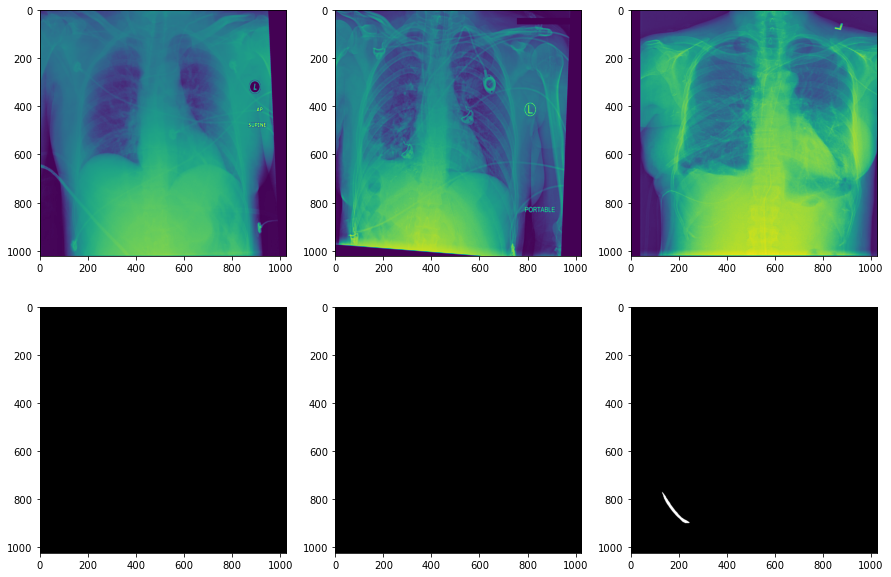

In [70]:
random_imgs_idxs = np.random.choice([i.split("_")[1] for i in os.listdir(data_path + "/siim_training")], 3)
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for idx, random_imgs_idx in enumerate(random_imgs_idxs):
    img_path = data_path + f"/siim_training/image_{random_imgs_idx}/images/image_{random_imgs_idx}.dcm"
    mask_path = data_path + f"/siim_training/image_{random_imgs_idx}/masks/mask_{random_imgs_idx}.png"
    img = pydicom.dcmread(img_path).pixel_array
    mask = plt.imread(mask_path)
    axs[0, idx].imshow(img)
    axs[1, idx].imshow(mask)

Let's now inspect the input message that we are to send to PlatypusSolver in order to run it.

In [5]:
import yaml
import json
with open(r"examples/siim_acr.yml") as stream:
    config = yaml.safe_load(stream)
    print(yaml.dump(config, indent=4, sort_keys=True))

object_detection: null
semantic_segmentation:
    data:
        colormap:
        -   - 0
            - 0
            - 0
        -   - 255
            - 255
            - 255
        column_sep: ;
        mode: nested_dirs
        shuffle: false
        subdirs:
        - images
        - masks
        train_path: examples/data/sim-arc/siim_training
        validation_path: examples/data/sim-arc/siim_validation
    ensemblers:
    -   augmentation:
            Blur:
                always_apply: false
                blur_limit: 7
                p: 0.5
            Flip:
                always_apply: false
                p: 0.5
            RandomRotate90:
                always_apply: false
                p: 0.5
            ToFloat:
                always_apply: true
                max_value: 255
                p: 1.0
        batch_size: 8
        callbacks:
            EarlyStopping:
                patience: 15
            ModelCheckpoint:
                filepath: examples/mode

Let's start from the top. In [Pyplatypus](https://github.com/maju116/pyplatypus) you can run two types of computer vision tasks:

 - object detection
 - semantic segmentation

In our case we are only interested in `semantic_segmentation` so the `object_detection` field will be empty.

In each taks we have to define at leat 2 major fileds and 1 optional:

 - `data` - responsible for the data injection information. With the fields:
  - `colormap` - it's a list of RGB tuples corresponding to different classes in the dataset. In our case we have only `background` and `nuclei`.
  - `mode` - defines how to read the data. In our case we can use `nested_dirs` specification, because each image/masks set is in a different subdirectory. In more complicated situation it's better to use `config_file` mode, then you will simply specify images ans masks paths in the CSV file.
  - `subdirs` - defines subdirectories names (or column names in case of `config_file` mode) for images and masks
  - `column_sep` - defines how the images/masks paths are separated in CSV config file.
  - `train_path` - path for the train directory or config file with images and masks.
  - `validation_path` - path for the validation directory or config file with images and masks.
  - `shuffle` - Should the data be shuffled in the data generator.
 - `models` - responsible for the models to train. It's defined as a list. Each element of a list is a model with unique `name` and model specification like model type (U-Net, U-Net++, Res-U_Net, Link-Net and more), augmentation pipeline, optimizer, evaluation metrics.
 - `ensemblers` - optional fiels that allows you to train ensembler model based on previously trained ones. The `submodels` field is responsible for ensembler input models.

# The model

# The model

The models present in the PyPlatypus segmentation submodule are U-Net based.

U-Net was originally developed for biomedical data segmentation. As you can see in the picture above architecture is very similar to autoencoder and it looks like the letter U, hence the name. Model is composed of 2 parts, and each part has some number of convolutional blocks (3 in the image above). Number of blocks will be hyperparameter in our model.

To build a U-Net model in platypus use u_net function. You have to specify:

* Number of convolutional blocks,
* Input image height and width - it need not to be in the form 2^N, as we added the generalizng layer.
* Indicator determining if the input image will be loaded as grayscale or RGB.
* Number of classes - in our case we have only 2 (background and nuclei).
* Additional arguments for CNN such as: number of filters, dropout rate etc.

Hereafter the models' building process is rather straightforward.

![68747470733a2f2f69322e77702e636f6d2f6e657074756e652e61692f77702d636f6e74656e742f75706c6f6164732f552d6e65742d6172636869746563747572652e706e673f73736c3d31.webp](attachment:68747470733a2f2f69322e77702e636f6d2f6e657074756e652e61692f77702d636f6e74656e742f75706c6f6164732f552d6e65742d6172636869746563747572652e706e673f73736c3d31.webp)

In [77]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver

ps = PlatypusSolver(
    config_yaml_path=Path("examples/siim_acr.yml")
)
ps.train()

10277 images detected!
Set 'steps_per_epoch' to: 643
3961 images detected!
Set 'steps_per_epoch' to: 248
Training model:  sim_acr_res_u_net
Epoch 1/100
643/643 [==============================] - 1001s 2s/step - loss: 0.0460 - tversky_coefficient: 0.6490 - iou_coefficient: 0.6172 - categorical_crossentropy: 0.1742 - val_loss: 0.0039 - val_tversky_coefficient: 0.5100 - val_iou_coefficient: 0.5033 - val_categorical_crossentropy: 0.0292
Epoch 2/100
643/643 [==============================] - 1013s 2s/step - loss: 0.0060 - tversky_coefficient: 0.7838 - iou_coefficient: 0.7713 - categorical_crossentropy: 0.0379 - val_loss: 0.0038 - val_tversky_coefficient: 0.5190 - val_iou_coefficient: 0.5139 - val_categorical_crossentropy: 0.0222
Epoch 3/100
643/643 [==============================] - 916s 1s/step - loss: 0.0059 - tversky_coefficient: 0.7874 - iou_coefficient: 0.7757 - categorical_crossentropy: 0.0353 - val_loss: 0.0036 - val_tversky_coefficient: 0.5214 - val_iou_coefficient: 0.5169 - val_cat

643/643 [==============================] - 892s 1s/step - loss: 0.0056 - tversky_coefficient: 0.7919 - iou_coefficient: 0.7814 - categorical_crossentropy: 0.0316 - val_loss: 0.0034 - val_tversky_coefficient: 0.5196 - val_iou_coefficient: 0.5146 - val_categorical_crossentropy: 0.0212
Epoch 28/100
643/643 [==============================] - 905s 1s/step - loss: 0.0055 - tversky_coefficient: 0.7918 - iou_coefficient: 0.7813 - categorical_crossentropy: 0.0317 - val_loss: 0.0034 - val_tversky_coefficient: 0.5221 - val_iou_coefficient: 0.5176 - val_categorical_crossentropy: 0.0194
Epoch 29/100
643/643 [==============================] - 902s 1s/step - loss: 0.0056 - tversky_coefficient: 0.7919 - iou_coefficient: 0.7814 - categorical_crossentropy: 0.0316 - val_loss: 0.0034 - val_tversky_coefficient: 0.5203 - val_iou_coefficient: 0.5155 - val_categorical_crossentropy: 0.0207
Epoch 30/100
643/643 [==============================] - 894s 1s/step - loss: 0.0055 - tversky_coefficient: 0.7918 - iou_co

Epoch 55/100
643/643 [==============================] - 891s 1s/step - loss: 0.0053 - tversky_coefficient: 0.7930 - iou_coefficient: 0.7829 - categorical_crossentropy: 0.0306 - val_loss: 0.0032 - val_tversky_coefficient: 0.5232 - val_iou_coefficient: 0.5190 - val_categorical_crossentropy: 0.0183
Epoch 56/100
643/643 [==============================] - 896s 1s/step - loss: 0.0053 - tversky_coefficient: 0.7935 - iou_coefficient: 0.7834 - categorical_crossentropy: 0.0303 - val_loss: 0.0032 - val_tversky_coefficient: 0.5224 - val_iou_coefficient: 0.5180 - val_categorical_crossentropy: 0.0189
Epoch 57/100
643/643 [==============================] - 891s 1s/step - loss: 0.0053 - tversky_coefficient: 0.7936 - iou_coefficient: 0.7836 - categorical_crossentropy: 0.0301 - val_loss: 0.0031 - val_tversky_coefficient: 0.5220 - val_iou_coefficient: 0.5176 - val_categorical_crossentropy: 0.0191
Epoch 58/100
643/643 [==============================] - 889s 1s/step - loss: 0.0053 - tversky_coefficient: 0.

Epoch 10/100
1285/1285 [==============================] - 834s 649ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0086 - val_categorical_crossentropy: 0.0086 - val_iou_coefficient: 0.5395
Epoch 11/100
1285/1285 [==============================] - 831s 647ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0087 - val_categorical_crossentropy: 0.0087 - val_iou_coefficient: 0.5395
Epoch 12/100
1285/1285 [==============================] - 830s 646ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0086 - val_categorical_crossentropy: 0.0086 - val_iou_coefficient: 0.5398
Epoch 13/100
1285/1285 [==============================] - 830s 646ms/step - loss: 0.0137 - categorical_crossentropy: 0.0137 - iou_coefficient: 0.8221 - val_loss: 0.0086 - val_categorical_crossentropy: 0.0086 - val_iou_coefficient: 0.5397
Epoch 14/100
1285/1285 [========================

1285/1285 [==============================] - 892s 694ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0083 - val_categorical_crossentropy: 0.0083 - val_iou_coefficient: 0.5396
Epoch 79/100
1285/1285 [==============================] - 881s 685ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0084 - val_categorical_crossentropy: 0.0084 - val_iou_coefficient: 0.5395
Epoch 80/100
1285/1285 [==============================] - 888s 691ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0083 - val_categorical_crossentropy: 0.0083 - val_iou_coefficient: 0.5397
Epoch 81/100
1285/1285 [==============================] - 886s 689ms/step - loss: 0.0134 - categorical_crossentropy: 0.0134 - iou_coefficient: 0.8221 - val_loss: 0.0083 - val_categorical_crossentropy: 0.0083 - val_iou_coefficient: 0.5393
Epoch 82/100
1285/1285 [==============================] - 879

Epoch 12/100
1285/1285 [==============================] - 959s 746ms/step - loss: 0.2009 - iou_coefficient: 0.7407 - categorical_crossentropy: 0.2009 - val_loss: 0.4727 - val_iou_coefficient: 0.4891 - val_categorical_crossentropy: 0.4727
Epoch 13/100
1285/1285 [==============================] - 941s 733ms/step - loss: 0.2860 - iou_coefficient: 0.7406 - categorical_crossentropy: 0.2860 - val_loss: 14.0258 - val_iou_coefficient: 0.4374 - val_categorical_crossentropy: 14.0258
Epoch 14/100
1285/1285 [==============================] - 1017s 791ms/step - loss: 0.3202 - iou_coefficient: 0.7379 - categorical_crossentropy: 0.3202 - val_loss: 14.4010 - val_iou_coefficient: 0.0091 - val_categorical_crossentropy: 14.4010
Epoch 15/100
1285/1285 [==============================] - 1009s 785ms/step - loss: 0.2799 - iou_coefficient: 0.7366 - categorical_crossentropy: 0.2799 - val_loss: 42.1565 - val_iou_coefficient: 0.0452 - val_categorical_crossentropy: 42.1565
Epoch 16/100
1285/1285 [================

## Fine tuning and model loading with Platypus

After saving the models you may want to simply load them ar fine-tune them later. To do so you can add to each model and esnsmbler 2 extra parameters:

 - `fine_tuning_path` - path for the model weights you want to load
 - `fit` - boolean value that specifies if you want to trin the model or only create the architecture.

In [7]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver

ps = PlatypusSolver(
    config_yaml_path=Path("examples/siim_acr.yml")
)
ps.train()

10277 images detected!
Set 'steps_per_epoch' to: 643
3961 images detected!
Set 'steps_per_epoch' to: 248
Training model:  sim_acr_res_u_net
Weights loaded from examples/models/sim_acr_res_u_net.hdf5
10277 images detected!
Set 'steps_per_epoch' to: 1285
3961 images detected!
Set 'steps_per_epoch' to: 496
Training model:  sim_acr_u_net_plus_plus
Weights loaded from examples/models/sim_acr_u_net_plus_plus.hdf5
10277 images detected!
Set 'steps_per_epoch' to: 1285
3961 images detected!
Set 'steps_per_epoch' to: 496
Training model:  sim_acr_res_u_net_u_net_plus_plus_ensembler
Weights loaded from examples/models/sim_acr_res_u_net_u_net_plus_plus_ensembler.hdf5


## Augmentation check
For the sake of sanity check, let's take a look at a sample of augmented images. It allows us to make sure that the augmentation effects are as we would expect.

In [8]:
augmented_images_res_u_net, augmented_images_u_net_plus_plus, augmented_images_res_u_net_u_net_plus_plus_ensembler = ps.sample_generators()

3961 images detected!
Set 'steps_per_epoch' to: 248
3961 images detected!
Set 'steps_per_epoch' to: 496
3961 images detected!
Set 'steps_per_epoch' to: 496


Let's display five augmented images for each model.

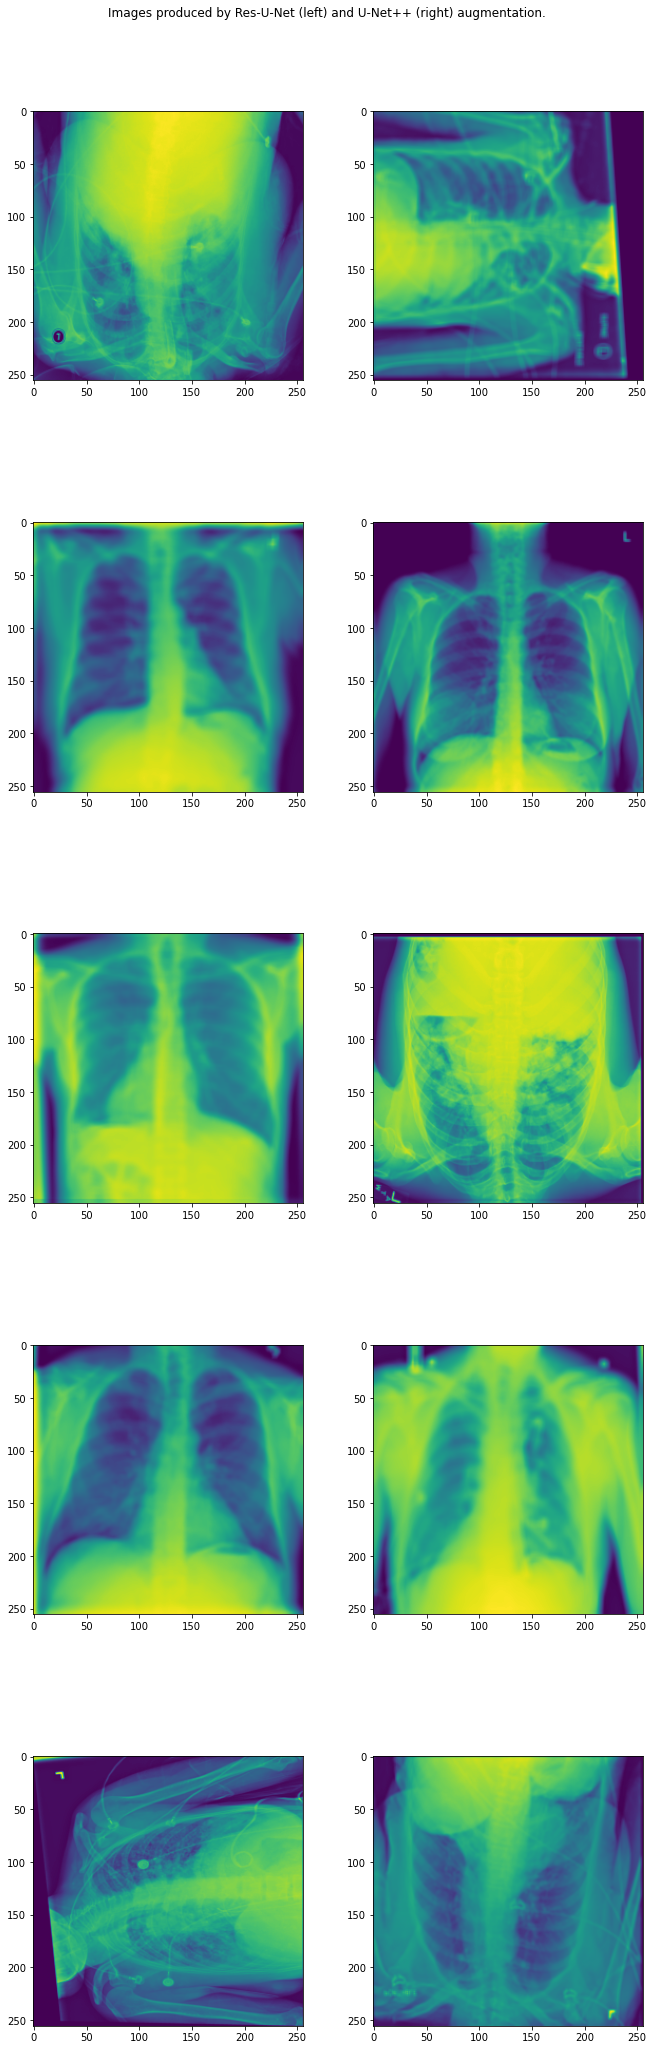

In [9]:
grid_length = 5
fig, axes = plt.subplots(grid_length, 2)
fig.suptitle("Images produced by Res-U-Net (left) and U-Net++ (right) augmentation.")
fig.set_size_inches(10, 30)
for aug1, aug2, i in zip(augmented_images_u_net_plus_plus[0][:grid_length], augmented_images_res_u_net[0][:grid_length], range(grid_length)):
    axes[(i, 0)].imshow(aug1)
    axes[(i, 1)].imshow(aug2)
fig.tight_layout(pad=4)

# Predictions

Only after do we train the models, we can easily produce predicted masks based on the validation set or whatever data that we would like to use, just make sure it is organized as in the train/validation/test sets.

### Models evaluation
Thanks to the evaluation-supporting methods of the PlatypusEngine, all created models may be quickly assesed.

In [78]:
metrics = ps.evaluate_models(task_type="semantic_segmentation")

3961 images detected!
Set 'steps_per_epoch' to: 248
248/248 [==============================] - 210s 848ms/step - loss: 0.0030 - tversky_coefficient: 0.5255 - iou_coefficient: 0.5218 - categorical_crossentropy: 0.0163
3961 images detected!
Set 'steps_per_epoch' to: 496
496/496 [==============================] - 202s 407ms/step - loss: 0.0083 - categorical_crossentropy: 0.0083 - iou_coefficient: 0.5396
3961 images detected!
Set 'steps_per_epoch' to: 496
496/496 [==============================] - 249s 502ms/step - loss: 0.0205 - iou_coefficient: 0.5409 - categorical_crossentropy: 0.0205
EVALUATION RESULTS:

                                    model_name  focal_loss  \
0                            sim_acr_res_u_net    0.002968   
0                      sim_acr_u_net_plus_plus         NaN   
0  sim_acr_res_u_net_u_net_plus_plus_ensembler         NaN   

   categorical_crossentropy  iou_coefficient  tversky_coefficient  cce_loss  
0                  0.525487         0.521756              0.0

## Plotting the predictions
Now we could take a look at the predicted masks to assess if our model is learning proper goals. Maybe it does not infere the expected shape of objects? In such case loss function could be replaced, or the new, topology-powered one could be designed to tackle the task.

In [10]:
# Ive chosen a subset of validation dataset for inference 
images_for_prediction_path = "examples/data/siim_validation_10"
ps.produce_and_save_predicted_masks_for_model(
    model_name="sim_acr_res_u_net",
    custom_data_path=images_for_prediction_path)

9 images detected!
Set 'steps_per_epoch' to: 1
1/1 [==============================] - 1s 740ms/step


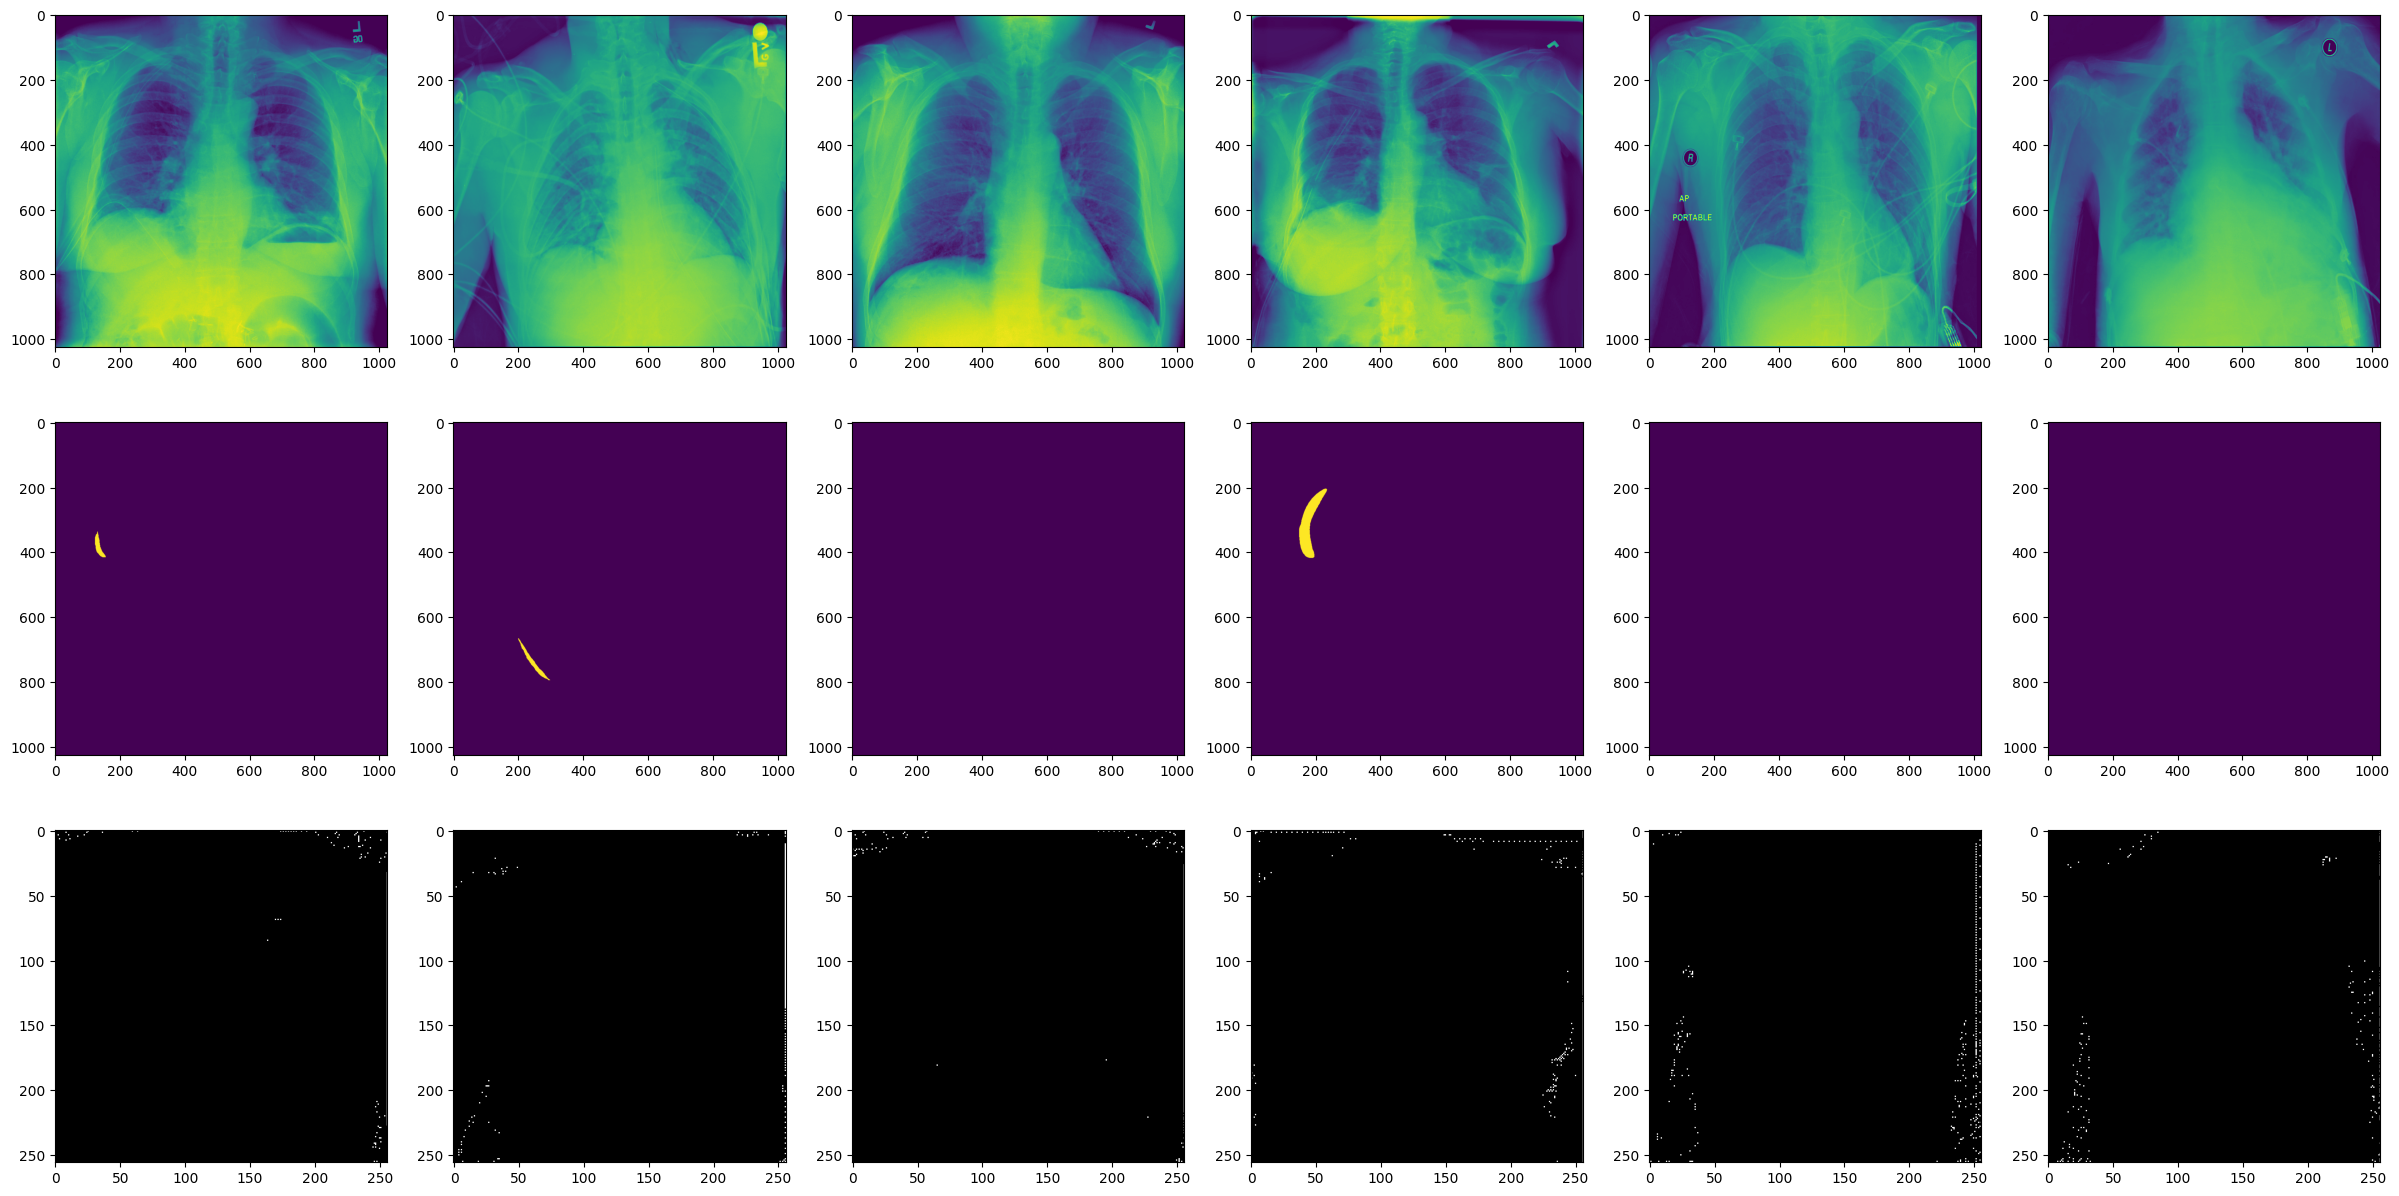

In [41]:
n=6
fig, axs = plt.subplots(3, n, figsize = (30,15))
for idx, file in enumerate(np.random.choice(os.listdir(images_for_prediction_path), n, replace=False)):
        path = os.path.join(images_for_prediction_path, file)
        dcm = pydicom.dcmread(path + "/images/" + file + ".dcm").pixel_array
        gt = plt.imread(path + "/masks/mask_" + file.split("_")[1] + ".png")
        mask = plt.imread(path + "/predicted_masks/" + file + "_res_u_net_predicted_mask.png")
        axs[0, idx].imshow(dcm)
        axs[1, idx].imshow(gt)
        axs[2, idx].imshow(mask)